<a href="https://colab.research.google.com/github/WillKWL/Project-KaggleCreditCard/blob/main/Kaggle_2A_ML_workflow_ADASYN_average_precision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import numpy as np
import re
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = [20, 5]
from matplotlib.pyplot import figure
import copy
from tqdm import tqdm
import seaborn as sns
from datetime import datetime

# packages for data_preparation pipeline
from scipy.stats import zscore
from matplotlib.patches import Rectangle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.decomposition import PCA 
from sklearn.ensemble import IsolationForest, RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import silhouette_score, average_precision_score
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
import sklearn
sklearn.set_config(display='diagram')

# pacakages for sampling pipeline
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

# packages for classification algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier

# packages for model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

# packages for hyperparameter tuning
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import RandomizedSearchCV, HalvingRandomSearchCV, GridSearchCV
from scipy.stats import randint, uniform, loguniform
from sklearn.utils import parallel_backend

# packages for loading and dumping models
from google.colab import drive, files
import os
from joblib import dump, load

# packages for ensemble learning
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier

In [ ]:
# def warn(*args, **kwargs):
#     pass
# import warnings
# warnings.warn = warn

In [ ]:
drive.mount('/content/drive')
# save to google drive
os.chdir('/content/drive/MyDrive/Colab Notebooks/Project-KaggleCreditCard')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read train set

In [ ]:
train_set = pd.read_pickle("kaggle_creditcard_train.pkl")
train_set

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.955041,-0.380783,-0.315013,0.330155,-0.509374,-0.086197,-0.627978,0.035994,1.054560,-0.030441,0.624996,1.691496,1.255790,-0.253266,-0.331695,0.307252,-0.930844,0.651666,0.167987,-0.125390,0.238197,0.968305,0.053208,-0.278602,-0.044999,-0.216780,0.045168,-0.047145,9.99,0
1,-0.400975,-0.626943,1.555339,-2.017772,-0.107769,0.168310,0.017959,-0.401619,0.040378,0.611115,-1.945070,-0.726597,1.060888,-1.193347,0.631053,-0.160123,-1.630444,2.106866,-1.692780,-0.470372,-0.153485,0.421703,0.113442,-1.004095,-1.176695,0.361924,-0.370469,-0.144792,45.90,0
2,0.072509,0.820566,-0.561351,-0.709897,1.080399,-0.359429,0.787858,0.117276,-0.131275,-0.638222,0.521931,-0.072768,-1.008237,-0.640249,-0.801946,0.678131,0.044374,0.521919,0.198772,0.012227,-0.314638,-0.872959,0.083391,0.148178,-0.431459,0.119690,0.206395,0.070288,11.99,0
3,-0.535045,1.014587,1.750679,2.769390,0.500089,1.002270,0.847902,-0.081323,0.371579,0.560595,-0.855437,-4.179628,0.286872,1.271254,-1.011647,1.458600,-0.613260,0.814931,-2.147124,-0.253757,0.063525,0.443431,-0.072754,0.448192,-0.655203,-0.181038,-0.093013,-0.064931,117.44,0
4,-4.026938,1.897371,-0.429786,-0.029571,-0.855751,-0.480406,-0.435632,1.313760,0.536044,1.221746,0.472626,1.595929,0.777603,0.187685,-1.060579,0.143332,0.007803,-0.055817,0.712695,-0.012320,-0.480691,-0.230369,0.250717,0.066399,0.470787,0.245335,0.286904,-0.322672,25.76,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227840,1.173488,0.100792,0.490512,0.461596,-0.296377,-0.213165,-0.165254,0.119221,-0.114199,0.079128,1.585195,0.777009,-0.476319,0.600937,0.658885,0.239566,-0.356782,-0.410923,-0.182494,-0.157534,-0.186027,-0.574283,0.161405,-0.006140,0.091444,0.109235,-0.020922,0.003967,1.98,0
227841,-0.775981,0.144023,-1.142399,-1.241113,1.940358,3.912076,-0.466107,1.360620,0.400697,-0.654029,-0.421422,0.346437,-0.041877,0.384625,0.785702,0.057999,-0.462528,-0.063197,0.094703,-0.295730,0.037078,-0.019575,0.241830,0.682820,-1.635109,-0.770941,0.066006,0.137056,89.23,0
227842,-0.146609,0.992946,1.524591,0.485774,0.349308,-0.815198,1.076640,-0.395316,-0.491303,-0.212753,-0.382362,0.022804,0.331641,-0.019493,0.690200,-0.144778,-0.539887,-0.068375,-0.229614,0.007155,0.052649,0.354089,-0.291198,0.402849,0.237383,-0.398467,-0.121139,-0.196195,3.94,0
227843,-2.948638,2.354849,-2.521201,-3.798905,1.866302,2.727695,-0.471769,2.217537,0.580199,-0.027572,-0.418939,0.570400,-0.294107,0.927786,-0.090065,0.426113,-0.396148,-0.946837,-1.143752,0.417396,-0.332759,-1.047514,0.143326,0.678869,0.319710,0.426309,0.496912,0.335822,1.00,0


# Exploratory data analysis
- features = PCA
- Y = Class

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227845 entries, 0 to 227844
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   V1      227845 non-null  float64 
 1   V2      227845 non-null  float64 
 2   V3      227845 non-null  float64 
 3   V4      227845 non-null  float64 
 4   V5      227845 non-null  float64 
 5   V6      227845 non-null  float64 
 6   V7      227845 non-null  float64 
 7   V8      227845 non-null  float64 
 8   V9      227845 non-null  float64 
 9   V10     227845 non-null  float64 
 10  V11     227845 non-null  float64 
 11  V12     227845 non-null  float64 
 12  V13     227845 non-null  float64 
 13  V14     227845 non-null  float64 
 14  V15     227845 non-null  float64 
 15  V16     227845 non-null  float64 
 16  V17     227845 non-null  float64 
 17  V18     227845 non-null  float64 
 18  V19     227845 non-null  float64 
 19  V20     227845 non-null  float64 
 20  V21     227845 non-null  f

In [ ]:
train_set.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,0.000916,-0.000384,-0.000920,-0.001458,0.000997,-0.000613,0.001090,-0.000383,0.000961,-0.001250,0.000577,-0.001405,0.000066,0.000004,0.000023,0.000668,0.000616,-0.000344,0.000113,0.000398,0.000215,-0.001215,0.000175,-0.000217,-0.000979,-0.000192,-0.000032,0.000257,88.479993
std,1.958337,1.656602,1.514545,1.415853,1.387667,1.336803,1.243493,1.188643,1.097553,1.086659,1.021130,1.001724,0.995426,0.959456,0.914004,0.877394,0.851612,0.838031,0.814306,0.774045,0.732617,0.725311,0.627103,0.605446,0.521764,0.482443,0.401821,0.329776,254.930277
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.320155,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.391307,-14.129855,-25.162799,-9.498746,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-9.895244,-15.430084,0.000000
25%,-0.919918,-0.597971,-0.890786,-0.849270,-0.688802,-0.768573,-0.552156,-0.208431,-0.642386,-0.536120,-0.763311,-0.406727,-0.647707,-0.425856,-0.581592,-0.467322,-0.484129,-0.498850,-0.455756,-0.211969,-0.228730,-0.542809,-0.161296,-0.354887,-0.317835,-0.327476,-0.070960,-0.052980,5.600000
50%,0.017978,0.066050,0.179041,-0.020959,-0.054711,-0.274846,0.041272,0.022233,-0.050414,-0.094026,-0.031764,0.139452,-0.014114,0.051191,0.048299,0.067910,-0.065443,-0.004699,0.004464,-0.062614,-0.029639,0.005491,-0.010595,0.040766,0.015101,-0.052011,0.001359,0.011366,22.000000
75%,1.315548,0.803898,1.025399,0.741630,0.611173,0.396056,0.570639,0.327504,0.599040,0.450669,0.740126,0.617962,0.661502,0.494204,0.648036,0.523986,0.400649,0.500715,0.458395,0.133017,0.186080,0.527408,0.148202,0.439790,0.350453,0.240813,0.091400,0.078464,77.100000
max,2.454930,22.057729,4.187811,16.875344,34.801666,73.301626,120.589494,20.007208,10.392889,15.245686,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000


In [ ]:
numeric_col = train_set.select_dtypes(include=np.number).columns.values.tolist()
print(f"number of numeric columns: {len(numeric_col)}")

number of numeric columns: 29


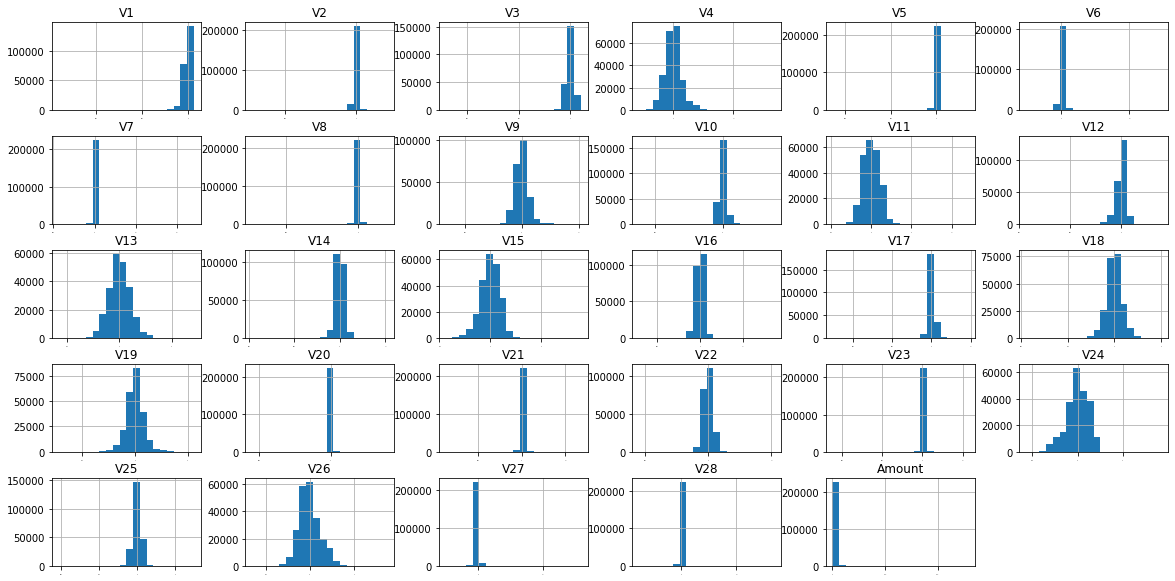

In [ ]:
# plot distributions of each numeric column
train_set.hist(bins=20, layout = (5, int(len(numeric_col) / 5) + 1), figsize= (20,10), xlabelsize=0)
plt.show()

## Class imbalance in y

In [ ]:
# % of data in each class
train_set.Class.value_counts(normalize=True)*100

0    99.827075
1     0.172925
Name: Class, dtype: float64

# Data preparation

In [ ]:
train_set["Amount"].values

(227845,)

In [ ]:
# make a copy and split X and y
X_train = train_set.drop(columns = ["Class", "Amount"]).reset_index(drop = True).copy(deep = True)
# amount = train_set["Amount"].values
y_train = train_set["Class"].values

In [ ]:
# X_train before data preparation
X_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,1.955041,-0.380783,-0.315013,0.330155,-0.509374,-0.086197,-0.627978,0.035994,1.054560,-0.030441,0.624996,1.691496,1.255790,-0.253266,-0.331695,0.307252,-0.930844,0.651666,0.167987,-0.125390,0.238197,0.968305,0.053208,-0.278602,-0.044999,-0.216780,0.045168,-0.047145
1,-0.400975,-0.626943,1.555339,-2.017772,-0.107769,0.168310,0.017959,-0.401619,0.040378,0.611115,-1.945070,-0.726597,1.060888,-1.193347,0.631053,-0.160123,-1.630444,2.106866,-1.692780,-0.470372,-0.153485,0.421703,0.113442,-1.004095,-1.176695,0.361924,-0.370469,-0.144792
2,0.072509,0.820566,-0.561351,-0.709897,1.080399,-0.359429,0.787858,0.117276,-0.131275,-0.638222,0.521931,-0.072768,-1.008237,-0.640249,-0.801946,0.678131,0.044374,0.521919,0.198772,0.012227,-0.314638,-0.872959,0.083391,0.148178,-0.431459,0.119690,0.206395,0.070288
3,-0.535045,1.014587,1.750679,2.769390,0.500089,1.002270,0.847902,-0.081323,0.371579,0.560595,-0.855437,-4.179628,0.286872,1.271254,-1.011647,1.458600,-0.613260,0.814931,-2.147124,-0.253757,0.063525,0.443431,-0.072754,0.448192,-0.655203,-0.181038,-0.093013,-0.064931
4,-4.026938,1.897371,-0.429786,-0.029571,-0.855751,-0.480406,-0.435632,1.313760,0.536044,1.221746,0.472626,1.595929,0.777603,0.187685,-1.060579,0.143332,0.007803,-0.055817,0.712695,-0.012320,-0.480691,-0.230369,0.250717,0.066399,0.470787,0.245335,0.286904,-0.322672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227840,1.173488,0.100792,0.490512,0.461596,-0.296377,-0.213165,-0.165254,0.119221,-0.114199,0.079128,1.585195,0.777009,-0.476319,0.600937,0.658885,0.239566,-0.356782,-0.410923,-0.182494,-0.157534,-0.186027,-0.574283,0.161405,-0.006140,0.091444,0.109235,-0.020922,0.003967
227841,-0.775981,0.144023,-1.142399,-1.241113,1.940358,3.912076,-0.466107,1.360620,0.400697,-0.654029,-0.421422,0.346437,-0.041877,0.384625,0.785702,0.057999,-0.462528,-0.063197,0.094703,-0.295730,0.037078,-0.019575,0.241830,0.682820,-1.635109,-0.770941,0.066006,0.137056
227842,-0.146609,0.992946,1.524591,0.485774,0.349308,-0.815198,1.076640,-0.395316,-0.491303,-0.212753,-0.382362,0.022804,0.331641,-0.019493,0.690200,-0.144778,-0.539887,-0.068375,-0.229614,0.007155,0.052649,0.354089,-0.291198,0.402849,0.237383,-0.398467,-0.121139,-0.196195
227843,-2.948638,2.354849,-2.521201,-3.798905,1.866302,2.727695,-0.471769,2.217537,0.580199,-0.027572,-0.418939,0.570400,-0.294107,0.927786,-0.090065,0.426113,-0.396148,-0.946837,-1.143752,0.417396,-0.332759,-1.047514,0.143326,0.678869,0.319710,0.426309,0.496912,0.335822


In [ ]:
# y_train before data preparation
y_train

[0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0]
Length: 227845
Categories (2, int64): [0, 1]

## Feature scaling - num_pipeline

In [ ]:
# create customer transformer to suppress n_quantile <= n_samples warning
class MyQuantileTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, output_distribution, random_state):
    self.output_distribution = output_distribution
    self.random_state = random_state
  
  def fit(self, X, y = None):
    self.QuantileTransformer = QuantileTransformer(n_quantiles=min(1000, X.shape[0]), # set this to suppress warning due to small dataset
                                                   output_distribution = self.output_distribution,
                                                   random_state = self.random_state).fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    try:
      self.output_names = X.columns
    except AttributeError: 
      pass
    output = self.QuantileTransformer.transform(output)
    return output
  
  def get_feature_names_out(self, names = None):
    try: 
      return self.output_names
    except AttributeError:
      pass

# create customer transformer to pass as df instead of array
class MyMinMaxScaler(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y = None):
    self.MinMaxScaler_ = MinMaxScaler().fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = pd.DataFrame(self.MinMaxScaler_.transform(output),
                          columns = X.columns)
    self.output_names = X.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

In [ ]:
num_pipeline = make_pipeline(
    
    MyMinMaxScaler()
    
    # feature scaling + outlier removal by transforming features into quantiles
      # some features have heavy tails, some look like normal so let's use transform them all to normal by quantile
      # instead of taking log for every feature
    # MyQuantileTransformer(output_distribution="uniform", random_state=42)
)

In [ ]:
# to be applied to only numeric columns
num_clean = pd.DataFrame(num_pipeline.fit_transform(X_train.select_dtypes(include=np.number)),
                         columns = num_pipeline.get_feature_names_out())
num_clean

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,0.991508,0.763241,0.914254,0.266566,0.762287,0.262153,0.261530,0.785772,0.606194,0.616505,0.322452,0.767945,0.545538,0.637537,0.305946,0.459123,0.704083,0.698111,0.576433,0.578930,0.565319,0.555202,0.666224,0.344693,0.575381,0.390038,0.239485,0.312167
1,0.951482,0.760643,0.949870,0.162484,0.764991,0.264712,0.265465,0.781077,0.563425,0.632611,0.169620,0.676807,0.530451,0.605929,0.378502,0.444260,0.683756,0.798195,0.431123,0.575257,0.559005,0.529703,0.667118,0.246933,0.511856,0.484568,0.229472,0.310186
2,0.959526,0.775917,0.909563,0.220461,0.772990,0.259406,0.270155,0.786643,0.556187,0.601247,0.316323,0.701450,0.370287,0.624526,0.270506,0.470918,0.732419,0.689188,0.578837,0.580396,0.556407,0.469307,0.666672,0.402201,0.553688,0.444999,0.243369,0.314550
3,0.949204,0.777964,0.953590,0.374695,0.769083,0.273097,0.270521,0.784513,0.577393,0.631342,0.234416,0.546662,0.470537,0.688797,0.254703,0.495738,0.713311,0.709340,0.395643,0.577563,0.562504,0.530717,0.664353,0.442628,0.541128,0.395876,0.236156,0.311806
4,0.889881,0.787278,0.912068,0.250619,0.759955,0.258190,0.262702,0.799478,0.584328,0.647940,0.313391,0.764344,0.508523,0.652364,0.251015,0.453910,0.731356,0.649453,0.618970,0.580134,0.553731,0.499284,0.669157,0.391181,0.604333,0.465523,0.245309,0.306576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227840,0.978230,0.768322,0.929593,0.272392,0.763721,0.260877,0.264349,0.786664,0.556907,0.619255,0.379551,0.733478,0.411461,0.666259,0.380599,0.456970,0.720763,0.625030,0.549064,0.578588,0.558481,0.483241,0.667831,0.381407,0.583040,0.443292,0.237893,0.313204
227841,0.945111,0.768778,0.898498,0.196913,0.778779,0.302352,0.262516,0.799981,0.578620,0.600850,0.260225,0.717250,0.445089,0.658986,0.390157,0.451196,0.717691,0.648946,0.570710,0.577117,0.562077,0.509118,0.669025,0.474244,0.486124,0.299517,0.239987,0.315905
227842,0.955803,0.777735,0.949285,0.273464,0.768068,0.254824,0.271915,0.781145,0.541004,0.611928,0.262548,0.705052,0.474002,0.645398,0.382959,0.444748,0.715443,0.648589,0.545384,0.580342,0.562328,0.526549,0.661109,0.436518,0.591231,0.360359,0.235478,0.309142
227843,0.908200,0.792106,0.872242,0.083528,0.778280,0.290444,0.262481,0.809173,0.586190,0.616577,0.260373,0.725691,0.425565,0.677249,0.324156,0.462903,0.719619,0.588172,0.473998,0.584710,0.556115,0.461164,0.667562,0.473711,0.595853,0.495085,0.250369,0.319939


## *Custom transformer - Clustering with MiniBatchKMeans
- After feature scaling
- Use silhouette score to measure performance of clustering
- Perform soft clustering with KMeans to differentiate clusters

In [ ]:
# from sklearn.cluster import MiniBatchKMeans

In [ ]:
# # create a custom transformer to cluster X_trains
# class ClusterDistance(BaseEstimator, TransformerMixin):
#   def __init__(self, n_clusters = 3, random_state = None, best_silh = False):
#     self.n_clusters = n_clusters
#     self.random_state = random_state
#     self.best_silh = best_silh
  
#   def fit(self, X, y = None, sample_weight = None, plot_silh = False):
#     self.feature_names_in_ = X.columns.values
#     self.index_names = X.sort_index().index.values
    
#     # find best k number of clusters based on silhouette score
#     if self.best_silh:
#       # test performance with silhouette score (distance from one's center and from other centers) from 2 to 10 clusters
#       # don't consider tuning k as hyperparameter because silhouette score is more intuitive
#       # e.g. clustering based on records from 1996 to 2022 (full range) vs clustering based on records from 2010 to 2022 (1st fold)
#       k_range = np.arange(2,11,1)
#       silh_scores = []
#       for k in range(2,11):
#         self.n_clusters = k
#         self.minibatchkmeans_ = MiniBatchKMeans(n_clusters = self.n_clusters, random_state=self.random_state)
#         self.minibatchkmeans_.fit(X)
#         silh_scores.append(silhouette_score(X, self.minibatchkmeans_.labels_))
      
#       max_k = k_range[np.argmax(silh_scores)]
#       max_silh = max(silh_scores)
#       self.n_clusters = max_k    

#       # plot silhouette scores for 2 - 10 clusters
#       if plot_silh:
#         plt.plot(k_range, silh_scores)
#         plt.xlabel("Number of clusters")
#         plt.ylabel("Silhouette score")
#         plt.title(f"optimal no. of cluster = {max_k}, silhouette score = {max_silh:0.4f}")
#         plt.show()
    
#     self.minibatchkmeans_ = MiniBatchKMeans(n_clusters = self.n_clusters, random_state=self.random_state)
#     self.minibatchkmeans_.fit(X)
#     return self
  
#   def transform(self, X):
#     # Soft Clustering: each column = distance to cluster i
#     X_clusterdist = pd.DataFrame(self.minibatchkmeans_.transform(X),
#                                  columns=[f"cluster_{i}" for i in range(self.n_clusters)])
#     # Scaling: Quantile transform the cluster distances like other numerical columns
#     # X_clusterdist = pd.DataFrame(MyQuantileTransformer(output_distribution="uniform", random_state=42).fit_transform(X_clusterdist),
#     #                              columns=[f"cluster_{i}" for i in range(self.n_clusters)])
#     # Scaling: MinMaxScale transform the cluster distances like other numerical columns
#     X_clusterdist = pd.DataFrame(MyMinMaxScaler().fit_transform(X_clusterdist),
#                                  columns=[f"cluster_{i}" for i in range(self.n_clusters)])
#     # merge with numerical columns to return
#     output = pd.concat([X, X_clusterdist], axis=1)
#     self.output_features = output.columns.values
#     return output
  
#   def get_feature_names_out(self, names = None):
#     return self.output_features

In [ ]:
# fit_similarity = ClusterDistance(random_state=42, best_silh=True).fit(num_clean, plot_silh=True)
# X_train_prepared = pd.DataFrame(fit_similarity.transform(num_clean),
#                                 columns = fit_similarity.get_feature_names_out())
# X_train_prepared

In [ ]:
# from sklearn.cluster import Birch
# Birch(threshold=0.1).fit_transform(num_clean)

### add to num_pipeline

In [ ]:
# # add to num_pipeline
# num_pipeline.steps.append(
#     ('X_train', SeasonSimilarity(random_state=42, n_clusters=2)) # choose 2 here instead of tuning as a hyperparameter
# )

In [ ]:
num_pipeline

Pipeline(steps=[('myminmaxscaler', MyMinMaxScaler())])

### Alternative: agglomerative clustering

In [ ]:
# from sklearn.cluster import AgglomerativeClustering
# from scipy.cluster.hierarchy import dendrogram

# # create a custom transformer to cluster nba seasons into era
# class SeasonSimilarity2(BaseEstimator, TransformerMixin):
#   def __init__(self, n_clusters = 3, compute_distances = True):
#     self.n_clusters = n_clusters
#     self.compute_distances = compute_distances
  
#   def fit(self, X, y = None, sample_weight = None):
#     # group by season to get league average
#     X_season = X.groupby("SEASON").mean().sort_index()
#     self.feature_names_in_ = X.columns.values
#     self.index_names = X_season.sort_index().index.values
#     self.agg_cluster_ = AgglomerativeClustering(n_clusters=self.n_clusters, compute_distances=self.compute_distances)
#     self.agg_cluster_.fit(X_season)
#     return self
  
#   def transform(self, X):
#     X_season = X.groupby("SEASON").mean().sort_index()
#     X_cluster = pd.DataFrame(self.agg_cluster_.predict(X_season), index = X_season.index, columns=[f"ERA_{i}" for i in range(self.n_clusters)]).reset_index()
#     output = X[["SEASON"]].merge(X_cluster, how = "inner", on = "SEASON")
#     output.drop(columns = ["SEASON"], inplace = True)
#     output.index = X[["SEASON"]]
#     self.output_features = output.columns.values
#     return output
  
#   def get_feature_names_out(self, names = None):
#     return self.output_features

#   def plot_dendrogram(self, **kwargs):
#     model = self.agg_cluster_
#     def create_plot(model, **kwargs):
#       # Create linkage matrix and then plot the dendrogram

#       # create the counts of samples under each node
#       counts = np.zeros(model.children_.shape[0])
#       n_samples = len(model.labels_)
#       for i, merge in enumerate(model.children_):
#           current_count = 0
#           for child_idx in merge:
#               if child_idx < n_samples:
#                   current_count += 1  # leaf node
#               else:
#                   current_count += counts[child_idx - n_samples]
#           counts[i] = current_count

#       linkage_matrix = np.column_stack(
#           [model.children_, model.distances_, counts]
#       )

#       # Plot the corresponding dendrogram
#       dendrogram(linkage_matrix, **kwargs)

#     create_plot(model, truncate_mode="level", p=20)
#     plt.xlabel("Number of points in node (or index of point if no parenthesis).")
#     locs, labels = plt.xticks() 
#     plt.xticks(locs, [season['SEASON'].unique().to_list()[int(x.get_text())] for x in labels])
#     plt.show()

In [ ]:
# agg_cluster = SeasonSimilarity2(n_clusters = 3, compute_distances=True).fit(X_train)
# agg_cluster.plot_dendrogram()

## Feature selection with lasso penalty
- use lasso penalty with logistic regression to select useful features
- threshold = hyperparameter to tune

In [ ]:
selector = SelectFromModel(
    SGDClassifier(random_state=42, loss='log', penalty='l1'),
    threshold=None # hyperparameter to tune
    ).fit(num_clean, y_train.reshape(-1,))

In [ ]:
# hyperparameter to tune
selector.threshold_

1e-05

In [ ]:
# original training set
X_train.shape

(227845, 28)

In [ ]:
# reduced no. of features
selector.transform(num_clean).shape

(227845, 6)

In [ ]:
# columns dropped
num_clean.columns[~selector.get_support()]

Index(['V1', 'V2', 'V3', 'V5', 'V6', 'V7', 'V8', 'V9', 'V13', 'V15', 'V16',
       'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28'],
      dtype='object')

In [ ]:
# columns retained
selector.get_feature_names_out()

array(['V4', 'V10', 'V11', 'V12', 'V14', 'V17'], dtype=object)

## Final pipeline = data_preparation



In [ ]:
num_pipeline

Pipeline(steps=[('myminmaxscaler', MyMinMaxScaler())])

In [ ]:
data_preparation = make_pipeline(
    
    # data cleaning
    ColumnTransformer([
        ("num", num_pipeline, make_column_selector(dtype_include=np.number)),
      ], 
      # drop remaining columns if any
      remainder="drop",
      # drop column prefix
      verbose_feature_names_out = False, 
    ),

    # feature selection
    SelectFromModel(
      SGDClassifier(random_state=42, loss='log', penalty='l1'),
      threshold=None # hyperparameter to tune
    )
)

## Over and under-sampling with imblearn
- Over-sampling to majority:minority class to 1:2
- Under-sampling majority:minority class to 1:1

In [ ]:
print(f"Size before sampling: {data_preparation.fit_transform(X_train, y_train).shape}")
print(f"% of positive class in y: {y_train.sum() / y_train.size*100:0.2f}%")

Size before sampling: (227845, 13)
% of positive class in y: 0.17%


In [ ]:
over_df = Pipeline(
    data_preparation.steps + [('over', ADASYN(random_state=42, sampling_strategy = 'minority'))]
).fit_resample(X_train, y_train)

# up-sample the minority class
print(f"Size after over-sampling: {over_df[0].shape}")
print(f"% of positive class in y: {over_df[1].sum() / len(over_df[1])*100:0.2f}%")

Size after over-sampling: (454919, 13)
% of positive class in y: 50.00%


In [ ]:
over_under_df = Pipeline(
    data_preparation.steps + [
        ('over', ADASYN(random_state=42, sampling_strategy = 0.5)),
        ('under', RandomUnderSampler(random_state=42, sampling_strategy=1))
        ]
).fit_resample(X_train, y_train)

# up-sample the minority class but keeps the dataset similar size
print(f"Size after over- and under-sampling: {over_under_df[0].shape}")
print(f"% of positive class in y: {over_under_df[1].sum() / len(over_under_df[1])*100:0.2f}%")

Size after over- and under-sampling: (227432, 6)
% of positive class in y: 50.00%


In [ ]:
data_preparation = Pipeline(
    data_preparation.steps + [
        ('over', ADASYN(random_state=42, sampling_strategy = 0.5)),
        ('under', RandomUnderSampler(random_state=42, sampling_strategy=1))
        ]
)

In [ ]:
data_preparation

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('myminmaxscaler',
                                                                   MyMinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5dea233ed0>)],
                                   verbose_feature_names_out=False)),
                ('selectfrommodel',
                 SelectFromModel(estimator=SGDClassifier(loss='log',
                                                         penalty='l1',
                                                         random_state=42))),
                ('over', ADASYN(random_state=42, sampling_strategy=0.5)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=1))])

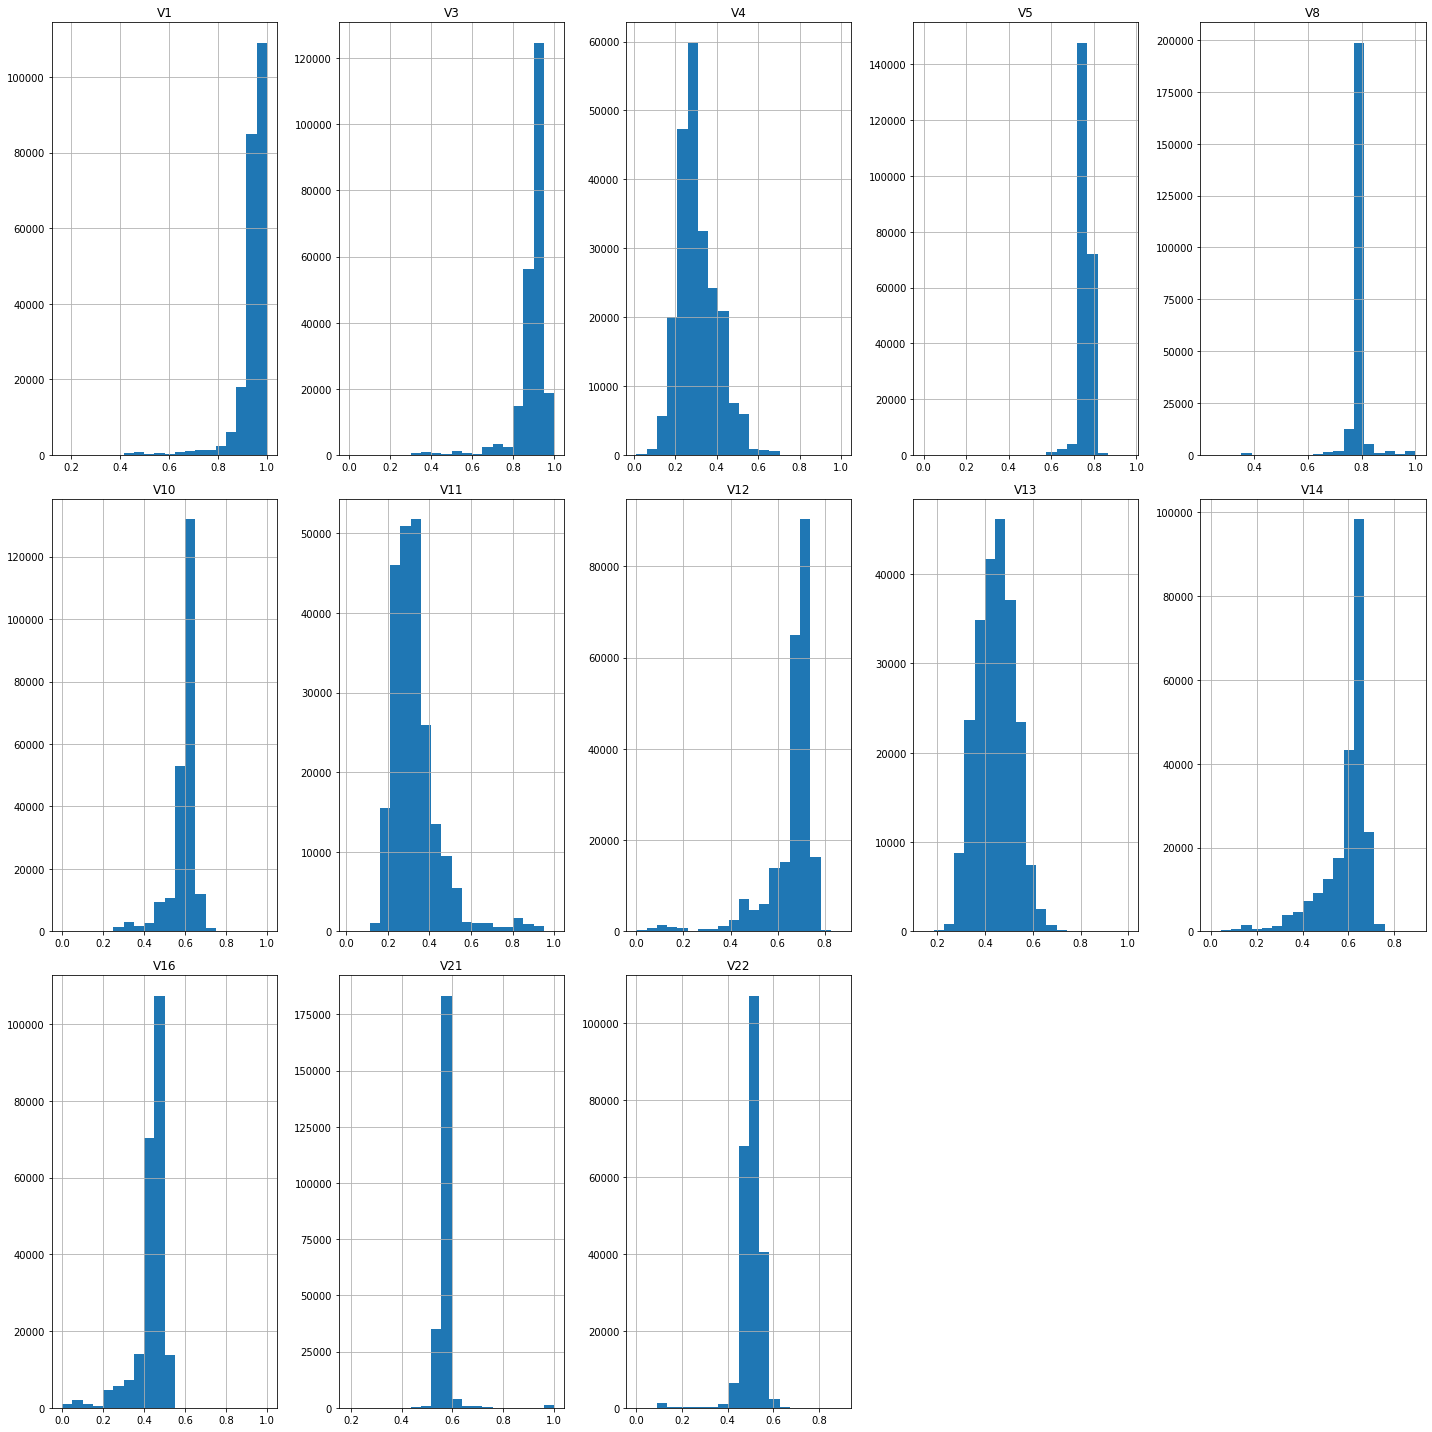

In [ ]:
# plot distributions of each feature in X_train
plot_df = pd.DataFrame(data_preparation.fit_resample(X_train, y_train)[0], 
                       columns = data_preparation.get_feature_names_out()).astype(float)
plot_df.hist(bins = 20, layout = (int(plot_df.shape[1] / 5) + 1, 5), figsize = (20,20))
plt.title("Distribution of each feature after cleaning")
plt.tight_layout()

# Shortlist promising models

In [ ]:
# create a list of models using standard hyperparameters to compare performance
# pick those with n_jobs available
# need predict_proba() for all classifiers such that we can use some ensemble methods later

dict_clf = {
    "knn": KNeighborsClassifier(),
    "sgd_log": SGDClassifier(random_state=42, loss='log', penalty='elasticnet'), # SGD solver for logistic regression
    "sgd_huber": SGDClassifier(random_state=42, loss='modified_huber', penalty='elasticnet'), # SGD solver for huber loss
    "bagging": BaggingClassifier(random_state=42),
    "extree": ExtraTreesClassifier(random_state=42),
    "forest": RandomForestClassifier(random_state=42),
    "xgb": XGBClassifier(random_state=42),
    "xgbrf": XGBRFClassifier(random_state=42)
}

In [ ]:
list_clf = []
AP_CVs = []
AP_train = []
list_precision = []
list_recall = []
list_thresholds = []
store_clf = []

cv = 10

# fit each classification algorithm and calculate 10-fold CV AP
for key, item in tqdm(dict_clf.items()):
  with parallel_backend('threading',n_jobs=-1):
    
    print(key)
    # add estimator after data_preparation pipeline
    clf = Pipeline(
        data_preparation.steps + [(key, item)]
        ).fit(X_train, y_train)
    
    # cross validation score
    AP_CV = cross_val_score(clf, X_train, y_train, cv = cv, scoring = 'average_precision')

    store_clf.append(clf)
    list_clf.append(key)
    AP_CVs.append(AP_CV)
    AP_train.append(average_precision_score(y_train, clf.predict_proba(X_train)[:,1]))

  0%|          | 0/8 [00:00<?, ?it/s]

knn


 12%|█▎        | 1/8 [00:35<04:10, 35.85s/it]

sgd_log


 25%|██▌       | 2/8 [00:51<02:23, 23.96s/it]

sgd_huber


 38%|███▊      | 3/8 [01:08<01:42, 20.57s/it]

bagging


 50%|█████     | 4/8 [03:55<05:14, 78.65s/it]

extree


 62%|██████▎   | 5/8 [05:51<04:36, 92.12s/it]

forest


 75%|███████▌  | 6/8 [14:10<07:41, 230.53s/it]

xgb


 88%|████████▊ | 7/8 [16:44<03:25, 205.44s/it]

xgbrf


100%|██████████| 8/8 [18:26<00:00, 138.26s/it]


In [ ]:
# sort the models by AP but not other performance metrics dependent on decision threshold, e.g. precision and recall
mean_AP = [np.mean(AP) for AP in AP_CVs]
sd_AP = [np.std(AP) for AP in AP_CVs]
print("Models sorted by cross validation AP score")
for mean, sd, clf_name in sorted(zip(mean_AP, sd_AP, list_clf), reverse = True):
  print(f"CV AP: AVG {mean:0.4f} / SD {sd:0.4f} / {clf_name}")

Models sorted by cross validation AP score
CV AP: AVG 0.7864 / SD 0.0404 / extree
CV AP: AVG 0.7628 / SD 0.0456 / forest
CV AP: AVG 0.7615 / SD 0.0379 / xgb
CV AP: AVG 0.6855 / SD 0.0743 / sgd_huber
CV AP: AVG 0.6689 / SD 0.0623 / sgd_log
CV AP: AVG 0.5771 / SD 0.1169 / xgbrf
CV AP: AVG 0.5191 / SD 0.0675 / bagging
CV AP: AVG 0.2507 / SD 0.0440 / knn


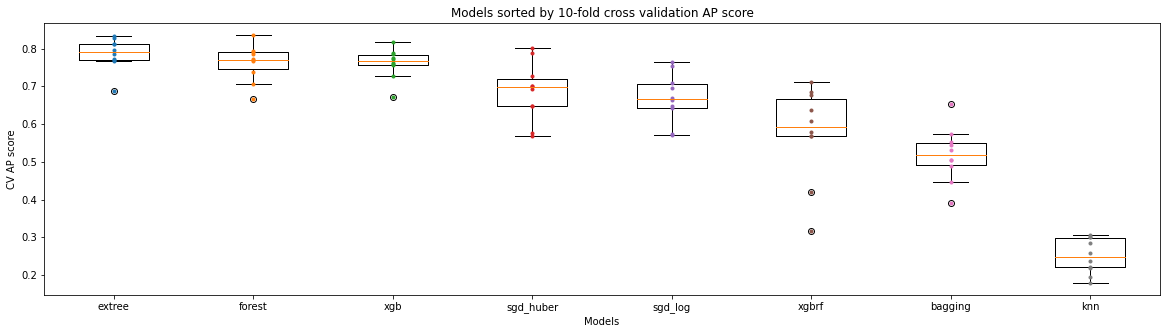

In [ ]:
# sort the models and plot the box plots of CV AP scores
mean_AP = [np.mean(AP) for AP in AP_CVs]
sorted_AP_CV = [i for _, i in [(mean_AP[i], AP_CVs[i]) for i in np.argsort(mean_AP)[::-1]]]
sorted_clf = [i for _, i in [(mean_AP[i], list_clf[i]) for i in np.argsort(mean_AP)[::-1]]]
sorted_AP_train = [i for _, i in [(mean_AP[i], AP_train[i]) for i in np.argsort(mean_AP)[::-1]]]
plt.boxplot(sorted_AP_CV, labels=sorted_clf)
# add dots for CV AP scores
for i, AP in enumerate(sorted_AP_CV):
  plt.plot([i+1]*len(AP), AP, ".")
plt.plot([*range(1,len(sorted_AP_CV)+1,1)], sorted_AP_train, "ks", label='AP on train set')
plt.title(f"Models sorted by {cv}-fold cross validation AP score")
plt.xlabel("Models")
plt.ylabel("CV AP score")
plt.legend()
plt.show()

# Fine-tune hyperparameters of shortlisted models with RandomizedSearchCV

In [ ]:
# print top models to tune
top = 3
for name in sorted_clf[:top]:
  print(name, dict_clf[name])

extree ExtraTreesClassifier(random_state=42)
forest RandomForestClassifier(random_state=42)
xgb XGBClassifier(random_state=42)


## Test the range of hyperparameters

In [ ]:
# create a list of hyperparameters to tune for each shortlisted classifier
shortlisted_clfs = {
    "extree": ExtraTreesClassifier(random_state=42), 
    "forest": RandomForestClassifier(random_state=42),
    "xgb": XGBClassifier(random_state=42)
    
}

param_grids = {
    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier
    "forest": {
        "forest__max_depth": randint(low = 50, high = 100), 
        "forest__criterion": ["gini", "entropy"],
        "forest__min_samples_split": uniform(loc = 0, scale = 0.3), # doesn't matter
        "forest__min_samples_leaf": uniform(loc = 0, scale = 0.1),
        "forest__min_impurity_decrease": uniform(loc = 0, scale = 0.001),
        "forest__max_features": uniform(loc = 0, scale = 0.4),
        "forest__min_impurity_decrease": uniform(loc = 0, scale = 0.07),
    },

     # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html?highlight=class_weight
    "extree": {
        "extree__max_depth": randint(low=20, high=500), 
        "extree__criterion": ["gini", "entropy"],
        # "extree__min_samples_split": randint(low = 2, high = 30),
        "extree__min_samples_leaf": randint(low = 1, high = 10),
        # "extree__min_impurity_decrease": uniform(loc = 0, scale = 0.07),
    },
     # https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
    "xgb": {
        "xgb__learning_rate": uniform(loc = 0.08, scale = 0.3 - 0.08),
        "xgb__gamma": uniform(loc = 0, scale = 20),
        # "xgb__max_depth": randint(low = 1, high = 10),
        # "xgb__min_child_weight": randint(low = 5, high = 50),
        # "xgb__subsample": uniform(loc = 0.01, scale = 1 - 0.01),
        # "xgb__colsample_bytree": uniform(loc = 0.5, scale = 1 - 0.5),
        "xgb__reg_lambda": loguniform(a = 10**-5, b = 10**-4),
        # "xgb__reg_alpha": uniform(loc = 0, scale = 100),
    },
    
}

In [ ]:
# testing reasonable range of hyperparameters before RandomizedSearchCV
clf_name = 'xgb'
full_pipeline = Pipeline(
      data_preparation.steps + [(clf_name, shortlisted_clfs[clf_name])]
      )
print(shortlisted_clfs[clf_name])

param_grid = copy.deepcopy(param_grids[clf_name])

with parallel_backend('threading', n_jobs=-1):
  random_search = RandomizedSearchCV(full_pipeline, 
                                    param_grid, 
                                    cv = 10, 
                                    n_iter = 5, 
                                    scoring = "average_precision",
                                    random_state = 42,
                                    # n_jobs = -1,
                                    error_score = 'raise')
  random_search.fit(X_train, y_train)
  print(pd.DataFrame(random_search.cv_results_).sort_values(['param_' + list(param_grid.keys())[-1]])[['param_' + x for x in list(param_grid.keys())] + ['mean_test_score', 'mean_fit_time', 'std_test_score']].head(5))

RandomForestClassifier(random_state=42)
  param_forest__max_depth  mean_test_score  mean_fit_time  std_test_score
4                      57         0.762771      89.152206        0.045646
2                      64         0.762771      88.237300        0.045646
1                      78         0.762771      87.671205        0.045646
0                      88         0.762771     101.498070        0.045646
3                      92         0.762771      90.374093        0.045646


## Set up hyperparameter grid

In [ ]:
# create a list of hyperparameters to tune for each shortlisted classifier
shortlisted_clfs = {
    "extree": ExtraTreesClassifier(random_state=42), 
    "xgb": XGBClassifier(random_state=42),
    
}

param_grids = {
    # https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
    "xgb": {
        "xgb__learning_rate": uniform(loc = 0.08, scale = 0.3 - 0.08),
        "xgb__gamma": uniform(loc = 0, scale = 20),
        # "xgb__max_depth": randint(low = 1, high = 10),
        # "xgb__min_child_weight": randint(low = 5, high = 50),
        # "xgb__subsample": uniform(loc = 0.01, scale = 1 - 0.01),
        # "xgb__colsample_bytree": uniform(loc = 0.5, scale = 1 - 0.5),
        "xgb__reg_lambda": loguniform(a = 10**-5, b = 10**-4),
        # "xgb__reg_alpha": uniform(loc = 0, scale = 100),
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html?highlight=class_weight
    "extree": {
        "extree__max_depth": randint(low=20, high=500), 
        "extree__criterion": ["gini", "entropy"],
        # "extree__min_samples_split": randint(low = 2, high = 30),
        "extree__min_samples_leaf": randint(low = 1, high = 10),
        # "extree__min_impurity_decrease": uniform(loc = 0, scale = 0.07),
    }    
}

In [ ]:
# specify folder to dump tuned models
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/Project-KaggleCreditCard')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Run RandomizedSearchCV to tune shortlisted models
random_clfs = []
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

for clf_name, clf in tqdm(shortlisted_clfs.items()):

  full_pipeline = Pipeline(
      data_preparation.steps + [(clf_name, clf)]
      )

  print(clf_name)
  print(clf)
  
  param_grid = copy.deepcopy(param_grids[clf_name])
  # tune threshold for feature selection in data_prepartion pipeline
  param_grid["selectfrommodel__threshold"] = loguniform(a = 10**-5, b = 10**0)
  
  print(param_grid)

  with parallel_backend('threading', n_jobs=-1):
    random_search = RandomizedSearchCV(full_pipeline, 
                                      param_grid, 
                                      cv = 10, 
                                      n_iter = 100, 
                                      scoring = "average_precision",
                                      random_state = 42,
                                      # n_jobs = -1,
                                      error_score = 'raise')

    random_search.fit(X_train, y_train)
    random_clfs.append(random_search)

    # print best scores
    print(f"\nbest_score: {random_search.best_score_}")
    print(f"best_params: {random_search.best_params_}")
    
    # dump the best model
    print(f'{clf_name} ADASYN AP {random_search.best_estimator_.steps[-1][0]} dumped {current_time}')
    dump(random_search, f'{clf_name}_tuned_AP_ADASYN_{current_time}.joblib') 

  0%|          | 0/2 [00:00<?, ?it/s]

extree
ExtraTreesClassifier(random_state=42)
{'extree__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4780919810>, 'extree__criterion': ['gini', 'entropy'], 'extree__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f47809196d0>, 'selectfrommodel__threshold': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f47809207d0>}

best_score: 0.807623552887492
best_params: {'extree__criterion': 'entropy', 'extree__max_depth': 403, 'extree__min_samples_leaf': 8, 'selectfrommodel__threshold': 0.17624510039685526}
extree ADASYN AP extree dumped 20221021_124632


 50%|█████     | 1/2 [2:27:42<2:27:42, 8862.74s/it]

xgb
XGBClassifier(random_state=42)
{'xgb__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f477d7b0fd0>, 'xgb__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f477d7b0490>, 'xgb__reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f477d877f90>, 'selectfrommodel__threshold': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f477d7b06d0>}


100%|██████████| 2/2 [6:39:06<00:00, 11973.25s/it]


best_score: 0.780852335099457
best_params: {'selectfrommodel__threshold': 0.000724586818114303, 'xgb__gamma': 15.528259214839936, 'xgb__learning_rate': 0.1549767788556639, 'xgb__reg_lambda': 8.526235532185119e-05}
xgb ADASYN AP xgb dumped 20221021_124632


## Check model performance after hyperparameter tuning

In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/Project-KaggleCreditCard')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tuned_models = {}
time_list = []
time_diff = []
# specify regex pattern to load latest models
match_pattern = '_tuned_AP_ADASYN_(\w+).joblib'

for time in [re.search(match_pattern, x).group(1) for x in os.listdir() if re.search(match_pattern, x) is not None]:
  time_diff.append(datetime.now() - datetime.strptime(time, "%Y%m%d_%H%M%S"))
  time_list.append(time)

latest = time_list[np.argmin(time_diff)]
for file in [x for x in os.listdir() if (re.search(match_pattern, x) is not None) and latest in x]:
  model = load(file)
  tuned_models[model.best_estimator_.steps[-1][0]] = model
  print(model.best_estimator_.steps[-1][0], "ADASYN AP loaded", latest)

extree ADASYN AP loaded 20221021_124632
xgb ADASYN AP loaded 20221021_124632


### Average precision (AUPRC)

In [ ]:
# pull the CV AP results from RandomizedSearchCV
tuned_AP = []
for clf_name, model in tuned_models.items():
  cv_AP_colindex = [i for i, x in enumerate(model.cv_results_.keys()) if re.search('split\w+_test_score', x) is not None]
  tuned_AP.append(pd.DataFrame(model.cv_results_).iloc[model.best_index_,cv_AP_colindex].values)

In [ ]:
# sort the models and plot the spread of CV AP scores
mean_tuned_AP = [np.mean(auc) for auc in tuned_AP]
mean_train_AP = [average_precision_score(y_train, model.best_estimator_.predict_proba(X_train)[:,1]) for _, model in tuned_models.items()]
sorted_tuned_AP = [i for _, i in sorted(zip(mean_tuned_AP, tuned_AP), reverse = True)]
sorted_tuned_clf = [i for _, i in sorted(zip(mean_tuned_AP, tuned_models.keys()), reverse = True)]
sorted_train_AP = [i for _, i in sorted(zip(mean_tuned_AP, mean_train_AP), reverse = True)]

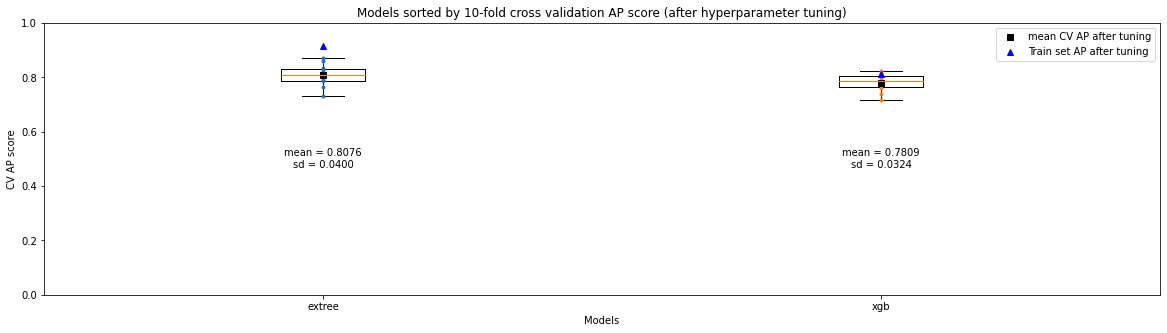

In [ ]:
plt.boxplot(sorted_tuned_AP, labels=sorted_tuned_clf)
# add dots for CV AP scores
for i, AP in enumerate(sorted_tuned_AP):
  plt.plot([i+1]*len(AP), AP, ".")
  plt.annotate(f"mean = {np.mean(AP):0.4f}\nsd = {np.std(AP):0.4f}",(i+1, 0.5), ha = 'center', va = 'center')

plt.plot([*range(1,len(sorted_tuned_AP)+1,1)], sorted(mean_tuned_AP, reverse=True), 
         "ks", label = 'mean CV AP after tuning')
plt.plot([*range(1,len(sorted_tuned_AP)+1,1)], sorted_train_AP, 
         "b^", label = 'Train set AP after tuning')
plt.legend()
plt.title(f"Models sorted by 10-fold cross validation AP score (after hyperparameter tuning)")
plt.xlabel("Models")
plt.ylim(0,1)
plt.ylabel("CV AP score")
plt.show()

### AUROC

In [ ]:
list_clf = []
auc_CVs = []
auc_train = []
list_precision = []
list_recall = []
list_thresholds = []

cv = 10

# fit each tuned model and calculate 10-fold CV AUC
for key, item in tqdm(tuned_models.items()):
  clf = item.best_estimator_.fit(X_train, y_train)
  auc_CV = cross_val_score(clf, X_train, y_train, cv = cv, scoring = 'roc_auc')
  try:
    y_scores = cross_val_predict(clf, X_train, y_train, cv = cv, method = 'predict_proba')[:,1] # second column = probability of positive class
  # if the classifier does not have decision_function attribute, then use predict_proba
  except AttributeError:
    print(f"{key} doesn't have predict_proba() method")
    y_scores = cross_val_predict(clf, X_train, y_train, cv = cv, method = 'decision_function')
  
  precision, recall, thresholds = precision_recall_curve(y_train, y_scores)

  list_clf.append(key)
  auc_CVs.append(auc_CV)
  auc_train.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
  list_precision.append(precision)
  list_recall.append(recall)
  list_thresholds.append(thresholds)

100%|██████████| 2/2 [09:29<00:00, 284.86s/it]


In [ ]:
sorted_tuned_AUC = [i for _, i in sorted(zip(mean_tuned_AP, auc_CVs), reverse = True)]
sorted_train_AUC = [i for _, i in sorted(zip(mean_tuned_AP, auc_train), reverse = True)]

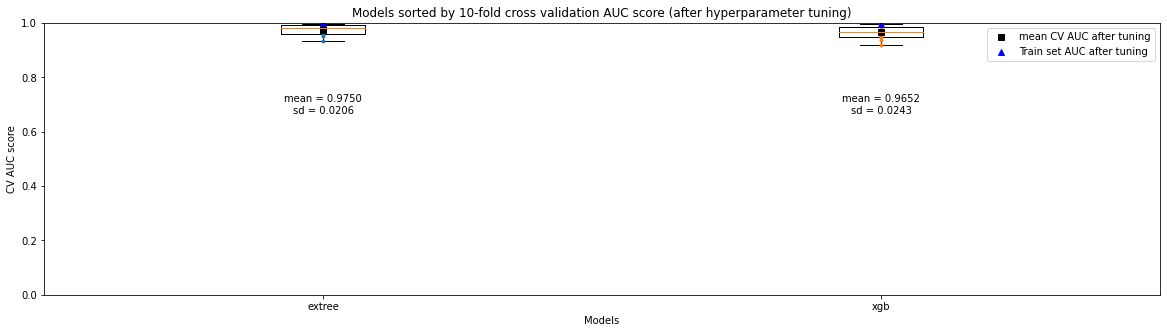

In [ ]:
plt.boxplot(sorted_tuned_AUC, labels=sorted_tuned_clf)
# add dots for CV AUC scores
for i, AUC in enumerate(sorted_tuned_AUC):
  plt.plot([i+1]*len(AUC), AUC, ".")
  plt.annotate(f"mean = {np.mean(AUC):0.4f}\nsd = {np.std(AUC):0.4f}",(i+1, 0.7), ha = 'center', va = 'center')

plt.plot([*range(1,len(sorted_tuned_AUC)+1,1)], [np.mean(x) for x in sorted_tuned_AUC], 
         "ks", label = 'mean CV AUC after tuning')
plt.plot([*range(1,len(sorted_tuned_AUC)+1,1)], sorted_train_AUC, 
         "b^", label = 'Train set AUC after tuning')
plt.legend()
plt.title(f"Models sorted by 10-fold cross validation AUC score (after hyperparameter tuning)")
plt.xlabel("Models")
plt.ylim(0,1)
plt.ylabel("CV AUC score")
plt.show()

### Coefficients and PR curve

In [ ]:
best_model = tuned_models['extree'].best_estimator_

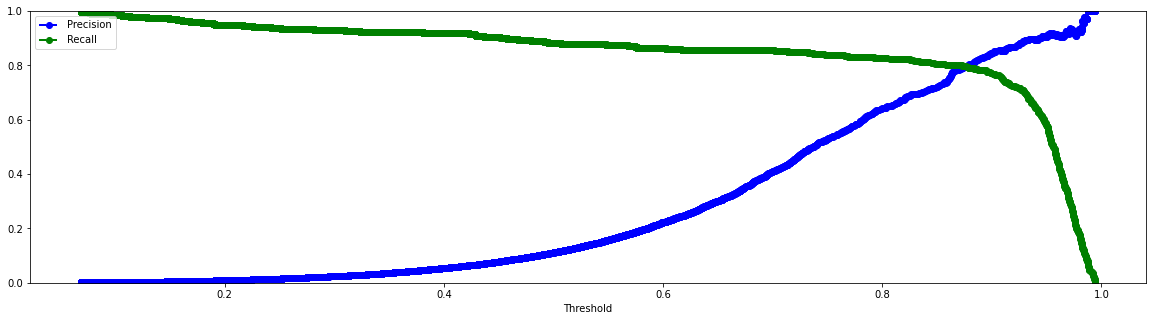

In [ ]:
# plot precision recall trade-off
idx = list_clf.index(best_model.steps[-1][0])
precisions = list_precision[idx]
recalls = list_recall[idx]
thresholds = list_thresholds[idx]
plt.plot(thresholds, precisions[:-1], 'b--o', label = "Precision", linewidth = 2)
plt.plot(thresholds, recalls[:-1], "g--o", label = "Recall", linewidth = 2)
plt.xlabel("Threshold")
plt.ylim(0,1)
plt.legend()
plt.show()

Number of features after fitting estimator with regularization: 
6
features = ['V4', 'V14', 'V17', 'V12', 'V11', 'V10']
coefficient = [0.2445, 0.2227, 0.1734, 0.1634, 0.1154, 0.0805]


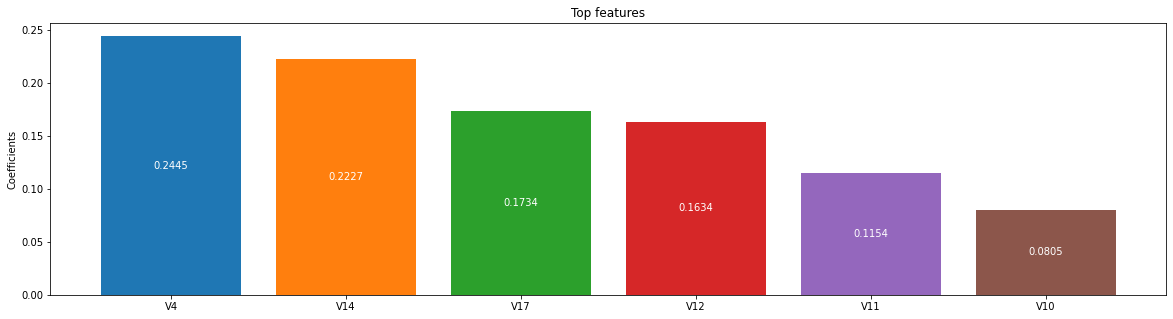

In [ ]:
# non-zero (signficant) features after regularization in fitting estimator
features_out = best_model[:-1].get_feature_names_out() 
coef = best_model.steps[-1][1].feature_importances_
print(f"Number of features after fitting estimator with regularization: \n{np.count_nonzero(coef)}")
features_non_zero = [features_out[loc] for loc in np.nonzero(coef)[0]]
coef_non_zero = [np.around(coef[loc], decimals=4) for loc in np.nonzero(coef)[0]]
print(f"features = {[feature_ for _, feature_ in sorted(zip(np.abs(coef_non_zero), features_non_zero), reverse=True)]}")
print(f"coefficient = {[coef_ for _, coef_ in sorted(zip(np.abs(coef_non_zero), coef_non_zero), reverse=True)]}")

abs_coef = np.abs(coef)
fig, ax = plt.subplots(1,1)
top_n = 10
for i, (_, coef, name) in enumerate(sorted(zip(abs_coef, coef, features_out), reverse=True)[:top_n]):
  ax.bar(name, coef)
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f"{height:0.4f}",
                xy=(rect.get_x() + rect.get_width() / 2, height/2),
                xytext=(0, 0),  # 3 points vertical offset
                textcoords="offset points",
                color = 'white',
                ha='center', va='center')
plt.title(f"Top features")
plt.ylabel("Coefficients")
plt.show()

# Ensemble methods
- Combining tuned models with ensemble learning

In [ ]:
# get performance from adaboost and bagging ensemble methods on each tuned model
single_clf_ensemble_models = {
    "Adaboost": AdaBoostClassifier(random_state = 42),
    "Bagging": BaggingClassifier(random_state = 42, n_estimators=50)
}

for ensemble_key, ensemble_model in single_clf_ensemble_models.items():
  for model in sorted_tuned_clf:
    ensemble_model.base_estimator = tuned_models[model].best_estimator_.steps[-1][1]
    ensemble_pipeline = Pipeline(data_preparation.steps + [(ensemble_key, ensemble_model)])

    ensemble_pipeline.fit(X_train, y_train)
    cv_score = cross_val_score(ensemble_pipeline, X_train, y_train, cv = 10, scoring = 'average_precision')
    print(f"mean AP = {np.mean(cv_score):0.4f}, std AP = {np.std(cv_score):0.4f}, {ensemble_key} {model}")

mean AP = 0.7876, std AP = 0.0374, Adaboost extree
mean AP = 0.0017, std AP = 0.0000, Adaboost xgb
mean AP = 0.7971, std AP = 0.0398, Bagging extree


In [ ]:
# get performance from voting and stacking ensemble methods on an increasing basket of tuned models
multiple_clf_ensemble_models = {
    "Voting": VotingClassifier(voting = 'soft', estimators = []),
    "Stacking": StackingClassifier(cv = 10, final_estimator=RandomForestClassifier(random_state=43), estimators = [])
}

for ensemble_key, ensemble_model in multiple_clf_ensemble_models.items():
  for i in range(1,len(tuned_models)):
    ensemble_model.estimators = [(model, tuned_models[model].best_estimator_.steps[-1][1]) for model in sorted_tuned_clf[:(i+1)]]
    ensemble_pipeline = Pipeline(data_preparation.steps + [(ensemble_key, ensemble_model)])

    ensemble_pipeline.fit(X_train, y_train)
    cv_score = cross_val_score(ensemble_pipeline, X_train, y_train, cv = 10, scoring = 'average_precision')
    print(f"mean AP = {np.mean(cv_score):0.4f}, std AP = {np.std(cv_score):0.4f}, {ensemble_key} {[model for model in sorted_tuned_clf[:(i+1)]]}")

mean AP = 0.8028, std AP = 0.0411, Voting ['extree', 'xgb']
mean AP = 0.3473, std AP = 0.0493, Stacking ['extree', 'xgb']
